# NTE Derivation in 1D for Tensor Trains
$$
\gdef\bo{\boldsymbol{\hat{\Omega}}}
\gdef\x{\boldsymbol{x}}
\gdef\o{\Omega}
\gdef\p{\partial}
\gdef\bm{\boldsymbol}
\gdef\bx{\boxed}
\gdef\f{\frac}
\gdef\:#1\:{\begin{align}#1\end{align}}
\gdef\(#1\){\begin{\pmatrix}#1\end{pmatrix}}
\gdef\[#1\]{\begin{\bmatrix}#1\end{bmatrix}}
\gdef\s#1{\Sigma_{#1}}
\gdef\m#1{\mathcal{#1}}
$$

The 1D discretized NTE using discrete ordinates approximation for the angular dependence is (according to NERS 561 notes):
$$
\:
\f{\mu_n}{\Delta x_i}&[\psi_{i + 1/2, n, g} - \psi_{i - 1/2, n, g}] + \s{t, i, g}\psi_{i, n, g} \
&= \sum_{g' = 1}^G\sum_{l = 0}^{L}(2l + 1)P_l(\mu_n)\s{sl, g'\rightarrow g}\phi_{l, i, g'} + \f{\chi_g}{k}\sum_{g' = 1}^{G}\nu\s{f, i, g'}\phi_{0, i, g'},
\:
$$
where $i\in\{0, 1, ..., I - 1\}$ is the cell index in a cell-centered scheme, $n\in\{0, 1, ..., N - 1\}$ is the ordinate index, $g\in\{1, 2, ..., G\}$ is the group index, and $l\in\{0, 1, ..., L\}$ is the Legendre polynomial order. The $l$th Legendre moment of the angular flux is
$$
\phi_{l, i, g}(x) = \int_{-1}^1P_l(\mu)\psi_{i, g}(\mu)d\mu \approx \sum_{n = 0}^{N - 1}w_nP_l(\mu_n)\psi_{i, g}(\mu_n) = \sum_{n = 0}^{N - 1}w_nP_l(\mu_n)\psi_{i, n, g},
$$
where
$$
\sum_{n = 0}^{N - 1}w_n = 1
$$

Scalar flux is defined as
$$
\phi_{i, g} = \phi_{0, i, g} \approx \sum_{n = 0}^{N - 1}w_n\psi_{i, n, g}.
$$
We approximate the scattering behavior as isotropic such that
$$
\sum_{l = 0}^{L}(2l + 1)P_l(\mu_n)\s{sl, g'\rightarrow g}\phi_{l, i, g'} \rightarrow\s{s0, g'\rightarrow g}\sum_{n = 0}^{N - 1}w_n\psi_{i, n, g'}
$$

The NTE then becomes
$$
\:
\f{\mu_n}{\Delta x_i}&[\psi_{i + 1/2, n, g} - \psi_{i - 1/2, n, g}] + \s{t, i, g}\psi_{i, n, g} \\
&= \sum_{g' = 1}^G\s{s0, g'\rightarrow g}\sum_{n = 0}^{N - 1}w_n\psi_{i, n, g'} + \f{\chi_g}{k}\sum_{g' = 1}^{G}\nu\s{f, i, g'}\sum_{n = 0}^{N - 1}w_n\psi_{i, n, g},
\:
$$
We can close the system with diamond difference,
$$
\psi_{i, n, g} = \f{1}{2}(\psi_{i + 1/2, n, g} + \psi_{i - 1/2, n, g}).
$$
Plugging this in we get
$$
\:
\f{\mu_n}{\Delta x_i}&[\psi_{i + 1/2, n, g} - \psi_{i - 1/2, n, g}] + \f{1}{2}\s{t, i, g}(\psi_{i + 1/2, n, g} + \psi_{i - 1/2, n, g}) \\
=&~ \f{1}{2}\sum_{g' = 1}^G\s{s0, g'\rightarrow g}\sum_{n = 0}^{N - 1}w_n(\psi_{i + 1/2, n, g'} + \psi_{i - 1/2, n, g'}) \\
&+ \f{\chi_g}{2k}\sum_{g' = 1}^{G}\nu\s{f, i, g'}\sum_{n = 0}^{N - 1}w_n(\psi_{i + 1/2, n, g'} + \psi_{i - 1/2, n, g'}).
\:
$$

In [9]:
%load_ext autoreload
%autoreload 2

import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['axes.grid'] = True

from discrete_ordinates import DiscreteOrdinates
from geometry import Geometry
from region import Region
from material import Material
from nuclide import Nuclide
from xs_server import XSServer
import benchmark_problems as problems
import plotting

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Example: Pu-239 from the [Criticality Verification Benchmark Suite](https://www.sciencedirect.com/science/article/pii/S0149197002000987/pdf?md5=299011580a5d17bc208703ef425a6ba6&pid=1-s2.0-S0149197002000987-main.pdf)

This problem includes a 1D brick of Pu-239 of width $3.707444~cm$ with one group of the following cross section information:

| $\s{t}~[cm^{-1}]$ | $\nu\s{f}~[cm^{-1}]$ | $\s{s}~[{cm^{-1}}]$ | $\chi_{1\rightarrow1}$ |
| :----------------- | :-------------------- | :------------------- | :---------------------- |
| 0.32640           | 0.264384             | 0.225216            | 1.0                    |

Below is the full matrix equation for $N=2$ and $I = 3$ with vacuum boundary conditions. The width of each cell is then $\Delta x = 3.707444~cm / I = 1.235815~cm$. 

The operators based on the NTE provided above are given below.

Streaming operator ($\bm H_x$):

| $\bm{H}_x$        | $\psi_{-1/2, 0}$       | $\psi_{1/2, 0}$        | $\psi_{3/2, 0}$        | $\psi_{5/2, 0}$       | $\psi_{-1/2, 1}$       | $\psi_{1/2, 1}$        | $\psi_{3/2, 1}$        | $\psi_{5/2, 1}$        |
| :----------------- | :---------------------- | :---------------------- | :---------------------- | :--------------------- | :---------------------- | :---------------------- | :---------------------- | :---------------------- |
| $\psi_{-1/2, 0}'$ | $\f{\mu_0}{\Delta x}$  |                        |                        |                       |                        |                        |                        |                        |
| $\psi_{1/2, 0}'$  | $-\f{\mu_0}{\Delta x}$ | $\f{\mu_0}{\Delta x}$  |                        |                       |                        |                        |                        |                        |
| $\psi_{3/2, 0}'$  |                        | $-\f{\mu_0}{\Delta x}$ | $\f{\mu_0}{\Delta x}$  |                       |                        |                        |                        |                        |
| $\psi_{5/2, 0}'$  |                        |                        | $-\f{\mu_0}{\Delta x}$ | $\f{\mu_0}{\Delta x}$ |                        |                        |                        |                        |
| $\psi_{-1/2, 1}'$ |                        |                        |                        |                       | -$\f{\mu_1}{\Delta x}$ | $\f{\mu_1}{\Delta x}$  |                        |                        |
| $\psi_{1/2, 1}'$  |                        |                        |                        |                       |                        | -$\f{\mu_1}{\Delta x}$ | $\f{\mu_1}{\Delta x}$  |                        |
| $\psi_{3/2, 1}'$  |                        |                        |                        |                       |                        |                        | -$\f{\mu_1}{\Delta x}$ | $\f{\mu_1}{\Delta x}$  |
| $\psi_{5/2, 1}'$  |                        |                        |                        |                       |                        |                        |                        | -$\f{\mu_1}{\Delta x}$ |

Total interaction operator ($\bm H_\Sigma$):

| $\bm{H}_\Sigma$   | $\psi_{-1/2, 0}$ | $\psi_{1/2, 0}$ | $\psi_{3/2, 0}$ | $\psi_{5/2, 0}$ | $\psi_{-1/2, 1}$ | $\psi_{1/2, 1}$ | $\psi_{3/2, 1}$ | $\psi_{5/2, 1}$ |
| ----------------- | ---------------- | --------------- | --------------- | --------------- | ---------------- | --------------- | --------------- | --------------- |
| $\psi_{-1/2, 0}'$ | $\s{t}/2$        |                 |                 |                 |                  |                 |                 |                 |
| $\psi_{1/2, 0}'$  | $\s{t}/2$        | $\s{t}/2$       |                 |                 |                  |                 |                 |                 |
| $\psi_{3/2, 0}'$  |                  | $\s{t}/2$       | $\s{t}/2$       |                 |                  |                 |                 |                 |
| $\psi_{5/2, 0}'$  |                  |                 | $\s{t}/2$       | $\s{t}/2$       |                  |                 |                 |                 |
| $\psi_{-1/2, 1}'$ |                  |                 |                 |                 | $\s{t}/2$        | $\s{t}/2$       |                 |                 |
| $\psi_{1/2, 1}'$  |                  |                 |                 |                 |                  | $\s{t}/2$       | $\s{t}/2$       |                 |
| $\psi_{3/2, 1}'$  |                  |                 |                 |                 |                  |                 | $\s{t}/2$       | $\s{t}/2$       |
| $\psi_{5/2, 1}'$  |                  |                 |                 |                 |                  |                 |                 | $\s{t}/2$       |

Scattering operator ($\bm S$):

| $\bm{S}$          | $\psi_{-1/2, 0}$ | $\psi_{1/2, 0}$ | $\psi_{3/2, 0}$ | $\psi_{5/2, 0}$ | $\psi_{-1/2, 1}$ | $\psi_{1/2, 1}$ | $\psi_{3/2, 1}$ | $\psi_{5/2, 1}$ |
| ----------------- | ---------------- | --------------- | --------------- | --------------- | ---------------- | --------------- | --------------- | --------------- |
| $\psi_{-1/2, 0}'$ |                  |                 |                 |                 |                  |                 |                 |                 |
| $\psi_{1/2, 0}'$  | $\s{s}w_0/2$     | $\s{s}w_0/2$    |                 |                 | $\s{s}w_1/2$     | $\s{s}w_1/2$    |                 |                 |
| $\psi_{3/2, 0}'$  |                  | $\s{s}w_0/2$    | $\s{s}w_0/2$    |                 |                  | $\s{s}w_1/2$    | $\s{s}w_1/2$    |                 |
| $\psi_{5/2, 0}'$  |                  |                 | $\s{s}w_0/2$    | $\s{s}w_0/2$    |                  |                 | $\s{s}w_1/2$    | $\s{s}w_1/2$    |
| $\psi_{-1/2, 1}'$ | $\s{s}w_0/2$     | $\s{s}w_0/2$    |                 |                 | $\s{s}w_1/2$     | $\s{s}w_1/2$    |                 |                 |
| $\psi_{1/2, 1}'$  |                  | $\s{s}w_0/2$    | $\s{s}w_0/2$    |                 |                  | $\s{s}w_1/2$    | $\s{s}w_1/2$    |                 |
| $\psi_{3/2, 1}'$  |                  |                 | $\s{s}w_0/2$    | $\s{s}w_0/2$    |                  |                 | $\s{s}w_1/2$    | $\s{s}w_1/2$    |
| $\psi_{5/2, 1}'$  |                  |                 |                 |                 |                  |                 |                 |                 |

Fission operator ($\bm F$):

| $\bm{F}$          | $\psi_{-1/2, 0}$ | $\psi_{1/2, 0}$ | $\psi_{3/2, 0}$ | $\psi_{5/2, 0}$ | $\psi_{-1/2, 1}$ | $\psi_{1/2, 1}$ | $\psi_{3/2, 1}$ | $\psi_{5/2, 1}$ |
| ----------------- | ---------------- | --------------- | --------------- | --------------- | ---------------- | --------------- | --------------- | --------------- |
| $\psi_{-1/2, 0}'$ |                  |                 |                 |                 |                  |                 |                 |                 |
| $\psi_{1/2, 0}'$  | $\nu\s{f}w_0/2$  | $\nu\s{f}w_0/2$ |                 |                 | $\nu\s{f}w_1/2$  | $\nu\s{f}w_1/2$ |                 |                 |
| $\psi_{3/2, 0}'$  |                  | $\nu\s{f}w_0/2$ | $\nu\s{f}w_0/2$ |                 |                  | $\nu\s{f}w_1/2$ | $\nu\s{f}w_1/2$ |                 |
| $\psi_{5/2, 0}'$  |                  |                 | $\nu\s{f}w_0/2$ | $\nu\s{f}w_0/2$ |                  |                 | $\nu\s{f}w_1/2$ | $\nu\s{f}w_1/2$ |
| $\psi_{-1/2, 1}'$ | $\nu\s{f}w_0/2$  | $\nu\s{f}w_0/2$ |                 |                 | $\nu\s{f}w_1/2$  | $\nu\s{f}w_1/2$ |                 |                 |
| $\psi_{1/2, 1}'$  |                  | $\nu\s{f}w_0/2$ | $\nu\s{f}w_0/2$ |                 |                  | $\nu\s{f}w_1/2$ | $\nu\s{f}w_1/2$ |                 |
| $\psi_{3/2, 1}'$  |                  |                 | $\nu\s{f}w_0/2$ | $\nu\s{f}w_0/2$ |                  |                 | $\nu\s{f}w_1/2$ | $\nu\s{f}w_1/2$ |
| $\psi_{5/2, 1}'$  |                  |                 |                 |                 |                  |                 |                 |                 |

These operators are then used to construct the eigenvalue problem
$$
[\bm H_x + \bm H_{\Sigma}]\Psi = \f{1}{k}\bm F \Psi.
$$
For a Gauss-Legendre quadrature set of $N = 2$: $\mu_0 = 0.5774$ and $\mu_1 = -0.5774$. The weights of these ordinates are $w_0 = w_1 = 0.5$. We can verify the $S_N$ solver in `discrete_ordinates.py` is building the tensors/matrices correctly.

### Discrete Ordinates Solver Implementation

The $S_N$ solver in `discrete_ordinates.py` builds the $d$-way operators based on the tensor cores provided in [Truong et al.](https://www.sciencedirect.com/science/article/pii/S002199912400192X#br0520). The tensor trains for $\mu_n > 0$ in 1D are
$$
\:
\bm {\m H}_x^{TT, 1} &= \bm I_G \circ \bm Q_{\mu} \circ \bm{D}_x^+,\\
\bm {\m H}_\Sigma^{TT, 1} &= \text{diag}(\Sigma_t)\circ(\bm{C}_1\otimes\bm{I}_{L/2})\circ \bm {Ip}_x^+,\\
\bm {\m F}^{TT, 1} &= \bm{\Sigma}_f \circ \bm{Intg}^1\circ\bm{Ip}_{x, noBC}^+,\\
\bm{\m S}^{TT, 1} &=  \bm{\Sigma}_s \circ \bm{Intg}^1\circ\bm{Ip}_{x, noBC}^+,
\:
$$
where all definitions are consistent with [Truong et al.](https://www.sciencedirect.com/science/article/pii/S002199912400192X#br0520); however, the definitions related to directions were reduced from 8 octants to 2 halfspaces. Additionally, the definition of the integral operator as defined in [Truong et al.](https://www.sciencedirect.com/science/article/pii/S002199912400192X#br0520) is incorrect. The integral operator is
$$
\bm{Intg}^1 = \bm A_1 \otimes (\bm 1_{L/2}\otimes w),
$$
where $\bm A_1$ is 
$$
\bm A_1 = \begin{pmatrix}
1 & 1\\
0 & 0
\end{pmatrix}.
$$
In general, $(\bm A_i)_{i:} = 1$ and zeros everywhere else for $i \in \{0, ..., 7\}$ in the case of 3D and $i \in \{0,1\}$ for 1D.

The `DiscreteOrdinates.solve_matrix_power()` method computes the tensor dots and Kronecker products to build the full $G\times N\times (I + 1)\times G\times N\times (I + 1)$ tensor operators and flattens it into a $GN(I + 1)\times GN(I + 1)$ matrix. It then converts these from `numpy.ndarray`s to `scipy.sparse.csc_matrix`s since all operators are ~99% sparse. It then computes the inverse of $\bm {H} =\bm {H}_x + \bm {H}_{\Sigma}$, $\bm {H}^{-1}$, and applies that to the right hand side of the matrix form NTE during power iteration.

To verify this solver we can compare the resulting operators to that defined in the prior section.

In [2]:
# Get problem XSs and geometry
xs_server, geometry = problems.pu_brick(4)

# Initialize SN solver
SN = DiscreteOrdinates(
    xs_server=xs_server, geometry=geometry, num_ordinates=2, tol=1e-6
)

print("\nStreaming + Total Interaction Operator")
pd.DataFrame(SN.H("full"))


Streaming + Total Interaction Operator


,0,1,2,3,4,5,6,7
0,0.630382,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,-0.303982,0.630382,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,-0.303982,0.630382,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,-0.303982,0.630382,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.630382,-0.303982,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.630382,-0.303982,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.630382,-0.303982
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.630382


In [3]:
print("Scattering Operator")
pd.DataFrame(SN.S("full"))

Scattering Operator


,0,1,2,3,4,5,6,7
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.056304,0.056304,0.000000,0.000000,0.056304,0.056304,0.000000,0.000000
2,0.000000,0.056304,0.056304,0.000000,0.000000,0.056304,0.056304,0.000000
3,0.000000,0.000000,0.056304,0.056304,0.000000,0.000000,0.056304,0.056304
4,0.056304,0.056304,0.000000,0.000000,0.056304,0.056304,0.000000,0.000000
5,0.000000,0.056304,0.056304,0.000000,0.000000,0.056304,0.056304,0.000000
6,0.000000,0.000000,0.056304,0.056304,0.000000,0.000000,0.056304,0.056304
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [4]:
print("Fission Operator")
pd.DataFrame(SN.F("full"))

Fission Operator


,0,1,2,3,4,5,6,7
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.066096,0.066096,0.000000,0.000000,0.066096,0.066096,0.000000,0.000000
2,0.000000,0.066096,0.066096,0.000000,0.000000,0.066096,0.066096,0.000000
3,0.000000,0.000000,0.066096,0.066096,0.000000,0.000000,0.066096,0.066096
4,0.066096,0.066096,0.000000,0.000000,0.066096,0.066096,0.000000,0.000000
5,0.000000,0.066096,0.066096,0.000000,0.000000,0.066096,0.066096,0.000000
6,0.000000,0.000000,0.066096,0.066096,0.000000,0.000000,0.066096,0.066096
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


All three operators match the operator matrices derived above.

### TT Paper Reproduction

Below is a reproduction of the ISFM results shown in [Truong et al.](https://www.sciencedirect.com/science/article/pii/S002199912400192X#br0520). We include 4 solvers below:

1. MGES: Matrix Generalized Eigenvalue Solver (in Compressed Sparse Column (CSC) format),
2. MPower: Matrix Power Iteration (in CSC format),
3. TTPower: Tensor Trains Power Iteration,
4. QTTPower: Quantized Tensor Trains Power Iteration.

MGES utilizes `DiscreteOrdinates.solve_ges()` which calls `scipy.sparse.linalg.eigs` with the operators in CSC format. Under the hood this function uses the Implicitly Restarted Arnoldi Method with ARPACK to find eigenvalues and eigenvectors. MPower utilizes `DiscreteOrdinates.solve_matrix_power()` which calls `scipy.sparse.linalg.inv` to invert the $H$ operator and then iterates on the angular flux until the tolerance is met. TTPower and QTTPower use Alternating Linear Scheme (ALS) in `DiscreteOrdinates.solve_TT_power()` to compute $\m x$ in $\bm{\m {A}}\m{x} = \m {b}$ when solving for the updated $\psi$.

-- MGES
--   N = 2, k = 0.80418, exec_time = 0.108 s
--   N = 4, k = 0.94714, exec_time = 0.313 s
--   N = 8, k = 0.99176, exec_time = 1.222 s
--   N = 16, k = 0.99847, exec_time = 5.017 s
--   N = 32, k = 0.99964, exec_time = 20.141 s
-- MPower
--   N = 2, k = 0.80418, exec_time = 0.362 s
--   N = 4, k = 0.94714, exec_time = 1.009 s
--   N = 8, k = 0.99176, exec_time = 3.207 s
--   N = 16, k = 0.99847, exec_time = 11.218 s
--   N = 32, k = 0.99964, exec_time = 41.386 s
-- TTPower
--   N = 2, k = 0.80418, exec_time = 1.764 s
--   N = 4, k = 0.94714, exec_time = 9.912 s
--   N = 8, k = 0.99174, exec_time = 10.423 s
--   N = 16, k = 0.99829, exec_time = 9.852 s
--   N = 32, k = 0.99943, exec_time = 10.434 s
-- QTTPower
--   N = 2, k = 0.80418, exec_time = 0.155 s
--   N = 4, k = 0.94714, exec_time = 0.257 s
--   N = 8, k = 0.99174, exec_time = 0.282 s
--   N = 16, k = 0.99829, exec_time = 0.318 s
--   N = 32, k = 0.99942, exec_time = 0.37 s


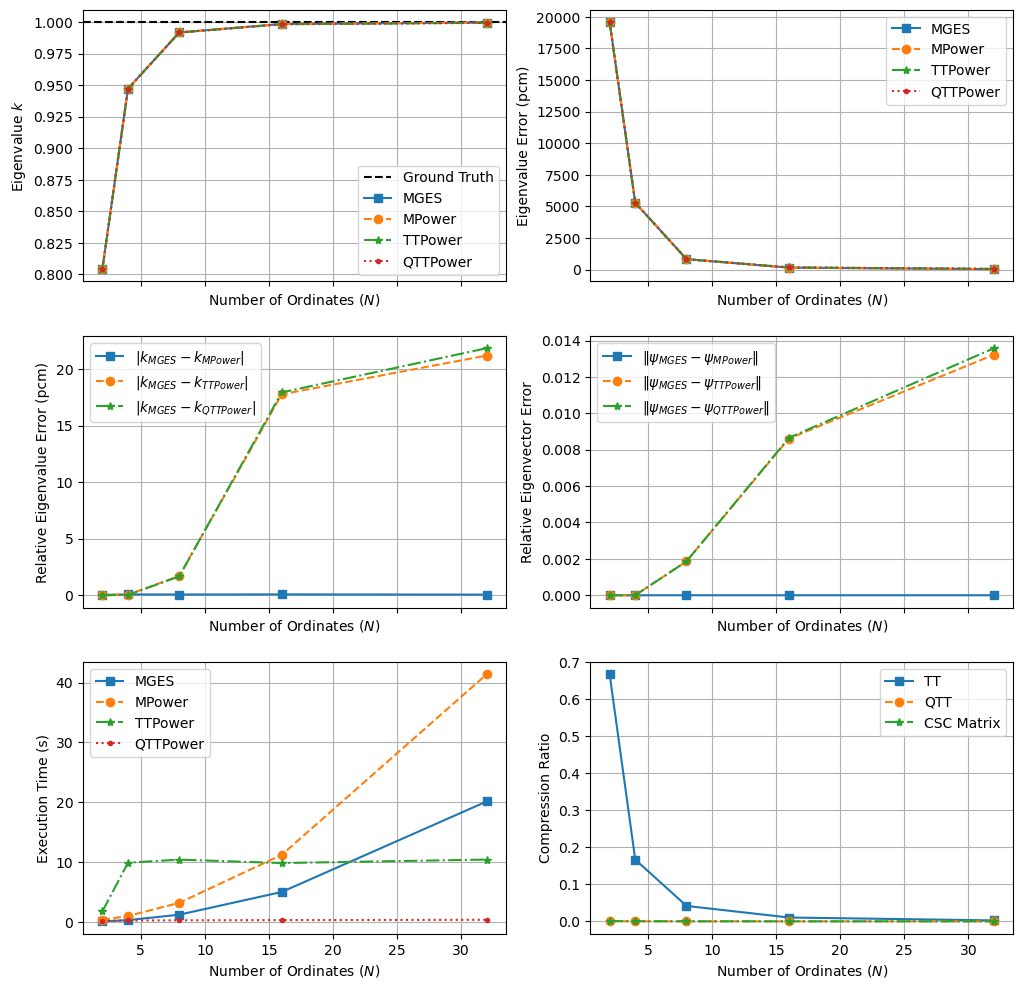

In [6]:
# Increase slab geometry fadelity
xs_server, geometry = problems.pu_brick(1024)

SN.update_settings(xs_server=xs_server, geometry=geometry)

solvers = {
    "MGES": (SN.solve_ges, {}, "s-"),
    "MPower": (SN.solve_matrix_power, {}, "o--"),
    "TTPower": (SN.solve_TT_power, {"tt_fmt": "tt"}, "*-."),
    "QTTPower": (SN.solve_TT_power, {"tt_fmt": "qtt"}, ".:"),
}

num_ordinates_list = [2, 4, 8, 16, 32]

expected_k = 1

ks_dict = {}
psis_dict = {}

tt_size = []
qtt_size = []
full_mat_size = []
csc_mat_size = []

fig, axs = plt.subplots(3, 2, figsize=(12, 12), sharex=True)
axs[0, 0].axhline(expected_k, color="k", ls="--", label="Ground Truth")

for method, solver in solvers.items():
    print(f"-- {method}")
    ks = []
    exec_times = []
    psis = []
    for num_ordinates in num_ordinates_list:
        print(f"--   N = {num_ordinates},", end=" ")
        
        # Update solver
        SN.update_settings(num_ordinates=num_ordinates, **solver[1])
    
        # Run and time solver
        start = time.time()
        k, psi = solver[0]()
        stop = time.time()
    
        ks.append(k)
        exec_times.append(stop - start)
        psis.append(psi)
        
        print(f"k = {np.round(k, 5)}, exec_time = {np.round(exec_times[-1], 3)} s")
        
        if method == "MGES":
            tt_size.append(0.0)
            qtt_size.append(0.0)
            full_mat_size.append(0.0)
            csc_mat_size.append(0.0)
            
            for tt in [SN.F, SN.S, SN.H]:
                # TT elements
                for core in tt("tt").cores:
                    tt_size[-1] += core.size
                
                # QTT elements
                for core in SN.tt2qtt(tt("tt")).cores:
                    qtt_size[-1] += core.size
                
                # Full matrix elements
                full_mat_size[-1] += tt("full").size
                
                # CSC matrix elements
                sp_mat = tt("csc")
                csc_mat_size[-1] = sp_mat.data.size + sp_mat.indices.size + sp_mat.indptr.size
    
    ks_dict[method] = np.array(ks)
    psis_dict[method] = psis
        
    axs[0, 0].plot(num_ordinates_list, ks, solver[-1], label=method)
    axs[0, 1].plot(num_ordinates_list, np.abs(np.array(ks) - expected_k) * 1e5, solver[-1], label=method)
    axs[2, 0].plot(num_ordinates_list, exec_times, solver[-1], label=method)

axs[0, 0].set(xlabel="Number of Ordinates ($N$)", ylabel="Eigenvalue $k$")
axs[0, 1].set(xlabel="Number of Ordinates ($N$)", ylabel="Eigenvalue Error (pcm)")
axs[2, 0].set(xlabel="Number of Ordinates ($N$)", ylabel="Execution Time (s)")

# Eigenvalue relative error
axs[1, 0].plot(
    num_ordinates_list, 
    np.abs(ks_dict["MGES"] - ks_dict["MPower"]) * 1e5, "s-", 
    label="$|k_{MGES} - k_{MPower}|$"
)
axs[1, 0].plot(
    num_ordinates_list, 
    np.abs(ks_dict["MGES"] - ks_dict["TTPower"]) * 1e5, "o--", 
    label="$|k_{MGES} - k_{TTPower}|$"
)
axs[1, 0].plot(
    num_ordinates_list, 
    np.abs(ks_dict["MGES"] - ks_dict["QTTPower"]) * 1e5, "*-.", 
    label="$|k_{MGES} - k_{QTTPower}|$"
)
axs[1, 0].set(xlabel="Number of Ordinates ($N$)", ylabel="Relative Eigenvalue Error (pcm)")

# Eigenvector relative error
axs[1, 1].plot(
    num_ordinates_list, 
    [np.linalg.norm(psis_dict["MGES"][i] - psis_dict["MPower"][i]) for i in range(len(num_ordinates_list))],
    "s-",
    label="$\|\psi_{MGES} - \psi_{MPower}\|$",
)
axs[1, 1].plot(
    num_ordinates_list, 
    [np.linalg.norm(psis_dict["MGES"][i] - psis_dict["TTPower"][i]) for i in range(len(num_ordinates_list))], 
    "o--",
    label="$\|\psi_{MGES} - \psi_{TTPower}\|$",
)
axs[1, 1].plot(
    num_ordinates_list, 
    [np.linalg.norm(psis_dict["MGES"][i] - psis_dict["QTTPower"][i]) for i in range(len(num_ordinates_list))], 
    "*-.",
    label="$\|\psi_{MGES} - \psi_{QTTPower}\|$",
)
axs[1, 1].set(xlabel="Number of Ordinates ($N$)", ylabel="Relative Eigenvector Error")

# Compression ratio plot
axs[2, 1].plot(num_ordinates_list, np.array(tt_size) / np.array(full_mat_size), "s-", label="TT")
axs[2, 1].plot(num_ordinates_list, np.array(qtt_size) / np.array(full_mat_size), "o--", label="QTT")
axs[2, 1].plot(num_ordinates_list, np.array(csc_mat_size) / np.array(full_mat_size), "*-.", label="CSC Matrix")
axs[2, 1].set(xlabel="Number of Ordinates ($N$)", ylabel="Compression Ratio")

for i in range(3):
    for j in range(2):
        axs[i, j].legend()

In all solution methods we approach the ground truth of $k = 1$ for this problem. The matrix GES and power iteration exactly match in their solution for $k$ and $\psi$ for all ordinate configurations. The TT power iteration solution diverges from the matrix GES and power iteration to within an error of 25 pcm. The QTT diverges more quickly but remains within 60 pcm for the highest dimensional case, $N = 32$. Both MGES and MPower exponentially increase in computational time with increasing number of ordinates. TTPower does not out perform MGES and MPower until the highest dimensional case; however, the computational cost of this can be reduced with a lower rank guess. This reduces accuracy though. QTTPower beats all solver for $N > 8$ and never breaks 1 s of run time. This is a $43.2\times$ speedup over MGES and $75.639\times$ speedup over MPower for $N = 32$. The compression ratio (# of elements in a given format / # of elements in matrix format) of the CSC and QTT compared to the full matrix format indicates a large reduction in memory. TT format also reduces the memory footprint and its compression ratio approaches CSC and QTT for higher $N$.  

#### Eigenvalue Dependence on Rank of the Guess

The execution time and correctness of the solution obtained from TTPower depends on the rank of the initial guess.

-- Rank = 2, k = 0.99299, exec_time = 2.126 s
-- Rank = 4, k = 0.99943, exec_time = 9.763 s
-- Rank = 6, k = 0.99963, exec_time = 10.179 s


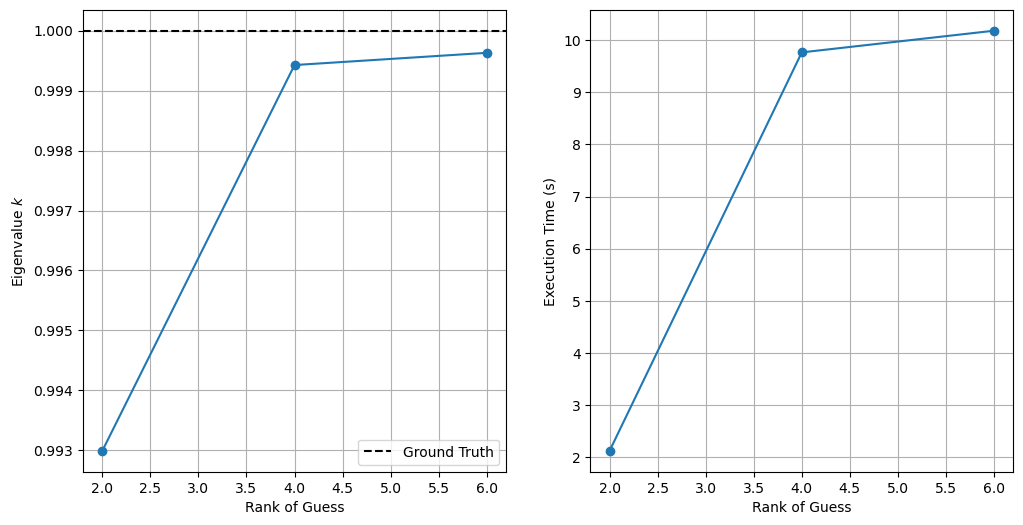

In [8]:
ranks = np.array([2, 4, 6], dtype=int)

ks = []
exec_times = []

fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharex=True)
axs[0].axhline(expected_k, color="k", ls="--", label="Ground Truth")

for rank in ranks:
    print(f"-- Rank = {rank},", end=" ")
    
    # Update solver
    SN.update_settings(num_ordinates=32, max_iter=1000, tt_fmt="tt")
    
    # Run and time solver
    start = time.time()
    k, _ = SN.solve_TT_power(ranks=rank)
    stop = time.time()
    
    ks.append(k)
    exec_times.append(stop - start)
        
    print(f"k = {np.round(k, 5)}, exec_time = {np.round(exec_times[-1], 3)} s")

axs[0].plot(np.array(ranks, dtype=int), ks, "-o")
axs[1].plot(np.array(ranks, dtype=int), exec_times, "-o")

axs[0].set(xlabel="Rank of Guess", ylabel="Eigenvalue $k$")
axs[1].set(xlabel="Rank of Guess", ylabel="Execution Time (s)")

axs[0].legend()

plt.show()

#### Effect of Region Splitting on QTT SVD

Left plots are Pu brick with 1 region, right plots are with 4 regions.

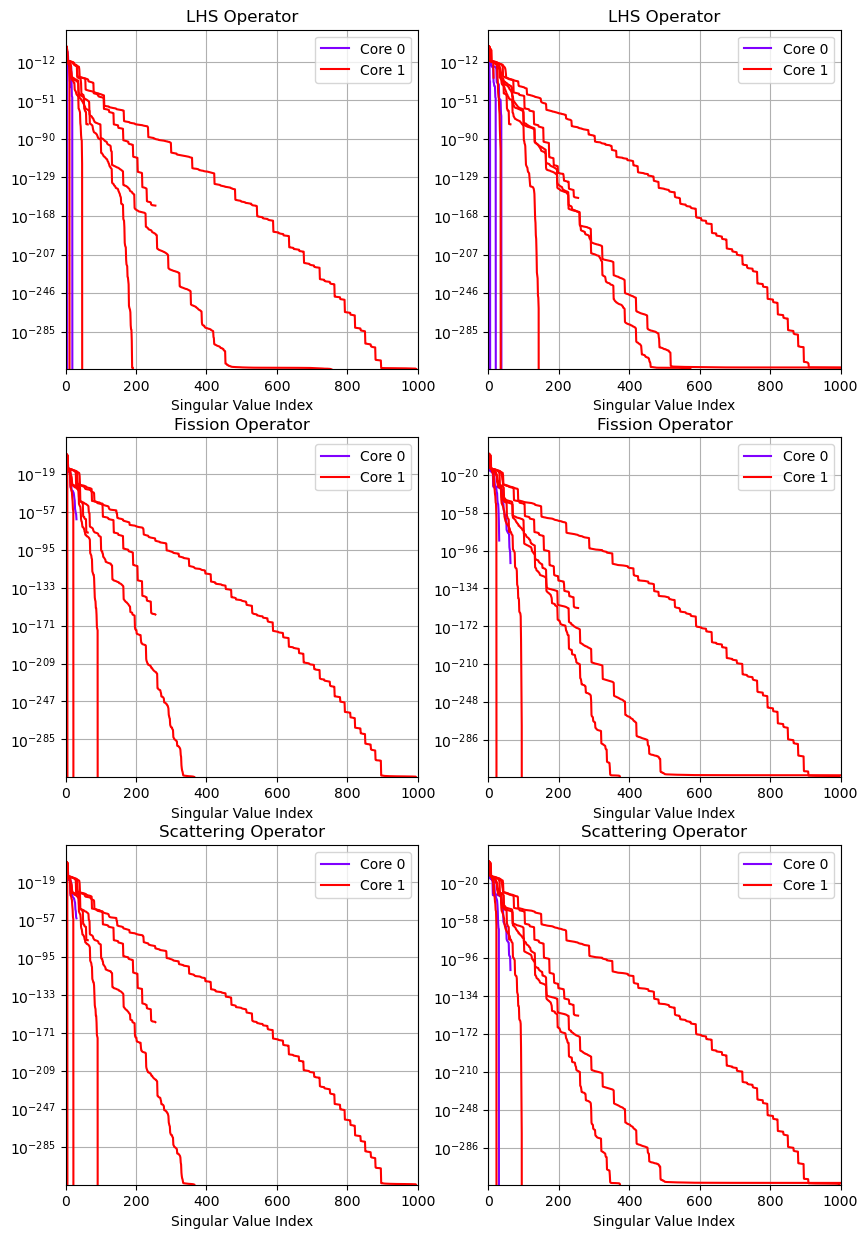

In [10]:
# Get problem specific XSs and geometry
xs_server, geometry = problems.pu_brick_multi_region(1024, 1)

# Initialize SN solver
SN = DiscreteOrdinates(
    xs_server=xs_server, 
    geometry=geometry, 
    num_ordinates=32, 
    tt_fmt="tt",
)

fig, axs = plt.subplots(3, 2, figsize=(10, 15))
plotting.plot_qtt_svd(SN, axs=axs[:, 0])

# Increase problem to 4 regions
xs_server, geometry = problems.pu_brick_multi_region(1024, 4)
SN.update_settings(xs_server=xs_server, geometry=geometry)
plotting.plot_qtt_svd(SN, axs=axs[:, 1])

plt.setp(axs, xlim=[0, 1000])
plt.show()

#### Sum of ranks of Cores in TT/QTT format

Plotting the ranks of the cores within the TT and QTT formats for varying numbers of regions in the Pu-239 brick problem. The SVD cutoff for QTT is set to $1\times 10^{-15}$. It appears the most effective decomposition occurs when the number of regions is a power of 2.

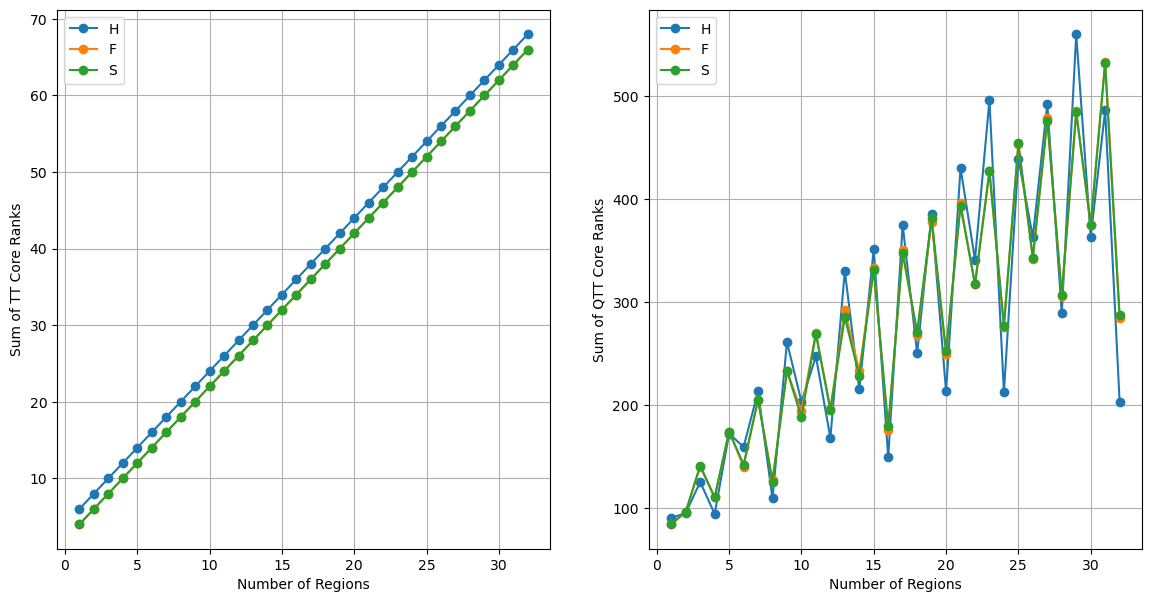

In [11]:
num_regions_list = np.arange(1, 33)

tt_ranks = {"H": [], "F": [], "S": []}
qtt_ranks = {"H": [], "F": [], "S": []}

for num_regions in num_regions_list:
    xs_server, geometry = problems.pu_brick_multi_region(1024, num_regions)

    SN.update_settings(xs_server=xs_server, geometry=geometry)
    tt_ranks["H"].append(np.sum(SN.H("tt").ranks))
    tt_ranks["F"].append(np.sum(SN.F("tt").ranks))
    tt_ranks["S"].append(np.sum(SN.S("tt").ranks))

    qtt_ranks["H"].append(np.sum(SN.tt2qtt(SN.H("tt")).ranks))
    qtt_ranks["F"].append(np.sum(SN.tt2qtt(SN.F("tt")).ranks))
    qtt_ranks["S"].append(np.sum(SN.tt2qtt(SN.S("tt")).ranks))

fig, axs = plt.subplots(1, 2, figsize=(14, 7))

for name, ranks in tt_ranks.items():
    axs[0].plot(num_regions_list, ranks, "o-", label=name)
axs[0].set(xlabel="Number of Regions", ylabel="Sum of TT Core Ranks")
axs[0].legend()

for name, ranks in qtt_ranks.items():
    axs[1].plot(num_regions_list, ranks, "o-", label=name)
axs[1].set(xlabel="Number of Regions", ylabel="Sum of QTT Core Ranks")
axs[1].legend()

plt.show()

## Example: Two-Group, Two-Media Benchmark from [Criticality Verification Benchmark Suite](https://www.sciencedirect.com/science/article/pii/S0149197002000987/pdf?md5=299011580a5d17bc208703ef425a6ba6&pid=1-s2.0-S0149197002000987-main.pdf)

The case considered here is given by Tables 40, 41, and 42 in the [Criticality Verification Benchmark Suite](https://www.sciencedirect.com/science/article/pii/S0149197002000987/pdf?md5=299011580a5d17bc208703ef425a6ba6&pid=1-s2.0-S0149197002000987-main.pdf). I will only consider research reactor (b) which has the following cross sections.


| Material         | $\nu_1$ | $\s{f, 1}$ | $\s{\gamma, 1}$ | $\s{s, 1\rightarrow 1}$ | $\s{s, 2\rightarrow 1}$ | $\s{t, 1}$ | $\chi_1$ |
| --------------- | ------ | ---------- | -------------- | ----------------------- | ----------------------- | ---------- | -------- |
| $H_2O + ^{235}U$ | $2.50$  | $0.000836$ | $0.001104$      | $0.83892$               | $0.04635$               | $0.88721$  | $1.0$    |
| $H_2O$           | $0.0$   | $0.0$      | $0.00074$       | $0.83957$               | $0.04749$               | $0.88798$  | $0.0$    |

| Material         | $\nu_2$ | $\s{f, 2}$ | $\s{\gamma, 2}$ | $\s{s, 2\rightarrow 2}$ | $\s{s, 1\rightarrow 2}$ | $\s{t, 2}$ | $\chi_2$ |
| ---------------- | ------- | ---------- | --------------- | ----------------------- | ----------------------- | ---------- | -------- |
| $H_2O + ^{235}U$ | $2.50$  | $0.029564$ | $0.024069$      | $2.9183$                | $0.000767$              | $2.9727$   | $0.0$    |
| $H_2O$           | $0.0$   | $0.0$      | $0.018564$      | $2.9676$                | $0.000336$              | $2.9865$   | $0.0$    |

The critical dimensions for the two region slab problem are $6.696802~cm$ and $1.126151~cm$. Here we define the $H_2O + ^{235}U$ mixture first along the $+x$ direction followed by the $H_2O$ reflector. There is a reflective boundary condition at $x = 0$ and a vacuum boundary condition at $x = 6.696802 + 1.126151~cm$.

In the below calculation, the solvers are the same as before, except the QTTPower method uses modified ALS (MALS) with adaptive ranks for the solution. This allows the ranks of the solution to change. The MALS algorithm is more computationally expensive than ALS, but the adaptive ranking of its solution offers some computational performance over setting a large rank for ALS to converge. As MALS converges the maximum rank of the solution is increased until the tolerance is met. In this two-region problem, convergence is not possible with a low rank (4 to 8) solution in the QTT format, so higher ranks in the cores (as high as 30) are needed. 

-- MGES
--   N = 2, k = 0.99059, exec_time = 0.301 s
--   N = 4, k = 0.99929, exec_time = 1.214 s
--   N = 8, k = 0.99985, exec_time = 4.964 s
--   N = 16, k = 0.99996, exec_time = 19.916 s
--   N = 32, k = 0.99999, exec_time = 79.632 s
-- MPower
--   N = 2, k = 0.98982, exec_time = 1.491 s
--   N = 4, k = 0.99855, exec_time = 4.169 s
--   N = 8, k = 0.99905, exec_time = 13.815 s
--   N = 16, k = 0.99918, exec_time = 49.945 s
--   N = 32, k = 0.99921, exec_time = 187.121 s
-- TTPower
--   N = 2, k = 0.98981, exec_time = 243.234 s
--   N = 4, k = 0.99851, exec_time = 692.703 s
--   N = 8, k = 0.99944, exec_time = 717.958 s
--   N = 16, k = 0.99968, exec_time = 740.235 s
--   N = 32, k = 0.99975, exec_time = 757.063 s
-- QTTPower
--   N = 2, k = 0.99053, exec_time = 30.979 s
--   N = 4, k = 0.99896, exec_time = 56.558 s
--   N = 8, k = 0.99975, exec_time = 141.822 s
--   N = 16, k = 0.99917, exec_time = 177.898 s
--   N = 32, k = 0.99926, exec_time = 599.074 s


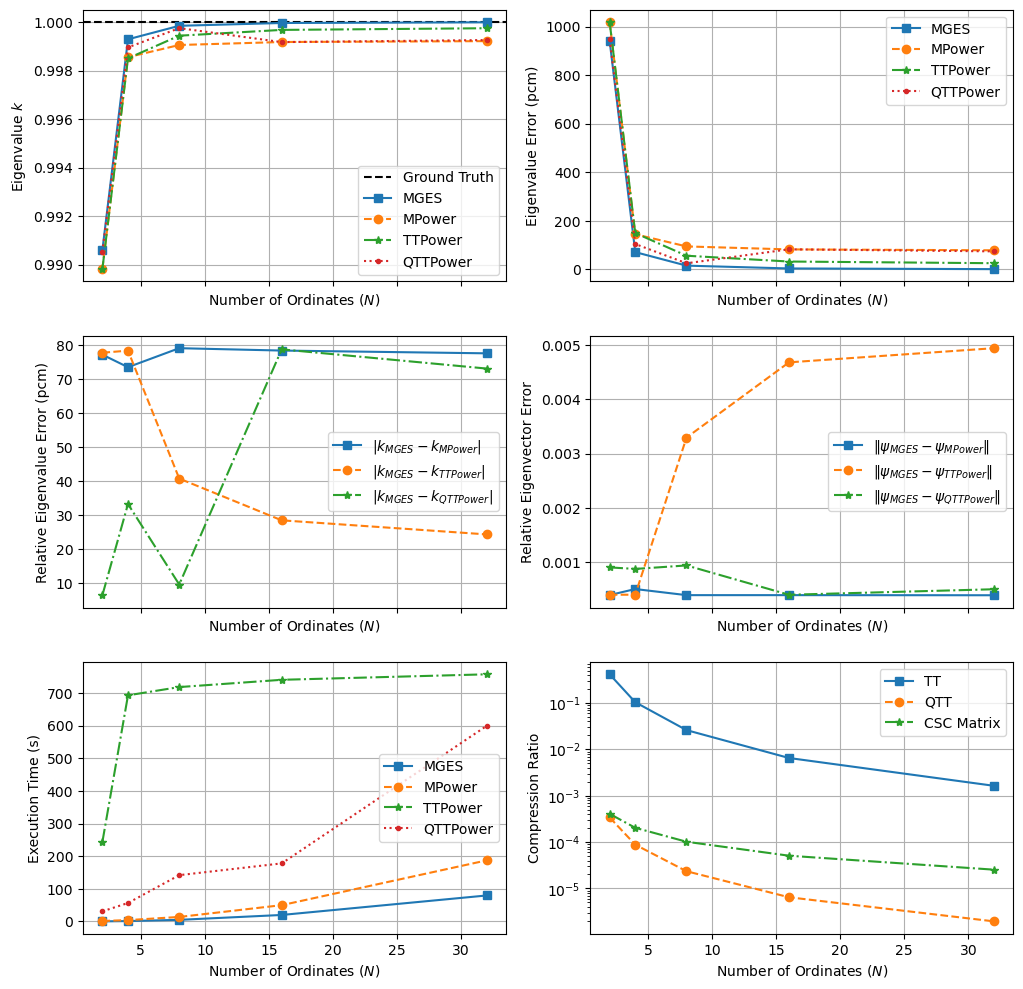

In [13]:
# Get problem specific XSs and geometry
xs_server, geometry = problems.research_reactor_multi_region([132, 760, 132], "vacuum")

# Initialize SN solver
SN = DiscreteOrdinates(
    xs_server=xs_server, 
    geometry=geometry, 
    num_ordinates=32, 
    tol=1e-5, 
    max_iter=2000,
    tt_fmt="tt",
    qtt_threshold=1e-15,
)

solvers = {
    "MGES": (SN.solve_ges, {}, {}, "s-"),
    "MPower": (SN.solve_matrix_power, {}, {}, "o--"),
    "TTPower": (SN.solve_TT_power, {"tt_fmt": "tt"}, {"method": "als"}, "*-."),
    "QTTPower": (SN.solve_TT_power, {"tt_fmt": "qtt"}, {"method": "mals"}, ".:"),
}

num_ordinates_list = [2, 4, 8, 16, 32]

expected_k = 1

ks_dict = {}
psis_dict = {}

tt_size = []
qtt_size = []
full_mat_size = []
csc_mat_size = []

fig, axs = plt.subplots(3, 2, figsize=(12, 12), sharex=True)
axs[0, 0].axhline(expected_k, color="k", ls="--", label="Ground Truth")

for method, solver in solvers.items():
    print(f"-- {method}")
    ks = []
    exec_times = []
    psis = []
    for num_ordinates in num_ordinates_list:
        print(f"--   N = {num_ordinates},", end=" ")
        
        # Update solver
        SN.update_settings(num_ordinates=num_ordinates, **solver[1])
    
        # Run and time solver
        start = time.time()
        k, psi = solver[0](**solver[2])
        stop = time.time()
    
        ks.append(k)
        exec_times.append(stop - start)
        psis.append(psi)
        
        print(f"k = {np.round(k, 5)}, exec_time = {np.round(exec_times[-1], 3)} s")
        
        if method == "MGES":
            tt_size.append(0.0)
            qtt_size.append(0.0)
            full_mat_size.append(0.0)
            csc_mat_size.append(0.0)
            
            for tt in [SN.F, SN.S, SN.H]:
                # TT elements
                for core in tt("tt").cores:
                    tt_size[-1] += core.size
                
                # QTT elements
                for core in SN.tt2qtt(tt("tt")).cores:
                    qtt_size[-1] += core.size
                
                # Full matrix elements
                full_mat_size[-1] += tt("full").size
                
                # CSC matrix elements
                sp_mat = tt("csc")
                csc_mat_size[-1] = sp_mat.data.size + sp_mat.indices.size + sp_mat.indptr.size
    
    ks_dict[method] = np.array(ks)
    psis_dict[method] = psis
        
    axs[0, 0].plot(num_ordinates_list, ks, solver[-1], label=method)
    axs[0, 1].plot(num_ordinates_list, np.abs(np.array(ks) - expected_k) * 1e5, solver[-1], label=method)
    axs[2, 0].plot(num_ordinates_list, exec_times, solver[-1], label=method)

axs[0, 0].set(xlabel="Number of Ordinates ($N$)", ylabel="Eigenvalue $k$")
axs[0, 1].set(xlabel="Number of Ordinates ($N$)", ylabel="Eigenvalue Error (pcm)")
axs[2, 0].set(xlabel="Number of Ordinates ($N$)", ylabel="Execution Time (s)")

# Eigenvalue relative error
axs[1, 0].plot(
    num_ordinates_list, 
    np.abs(ks_dict["MGES"] - ks_dict["MPower"]) * 1e5, "s-", 
    label="$|k_{MGES} - k_{MPower}|$"
)
axs[1, 0].plot(
    num_ordinates_list, 
    np.abs(ks_dict["MGES"] - ks_dict["TTPower"]) * 1e5, "o--", 
    label="$|k_{MGES} - k_{TTPower}|$"
)
axs[1, 0].plot(
    num_ordinates_list, 
    np.abs(ks_dict["MGES"] - ks_dict["QTTPower"]) * 1e5, "*-.", 
    label="$|k_{MGES} - k_{QTTPower}|$"
)
axs[1, 0].set(xlabel="Number of Ordinates ($N$)", ylabel="Relative Eigenvalue Error (pcm)")

# Eigenvector relative error
axs[1, 1].plot(
    num_ordinates_list, 
    [np.linalg.norm(psis_dict["MGES"][i] - psis_dict["MPower"][i]) for i in range(len(num_ordinates_list))],
    "s-",
    label="$\|\psi_{MGES} - \psi_{MPower}\|$",
)
axs[1, 1].plot(
    num_ordinates_list, 
    [np.linalg.norm(psis_dict["MGES"][i] - psis_dict["TTPower"][i]) for i in range(len(num_ordinates_list))], 
    "o--",
    label="$\|\psi_{MGES} - \psi_{TTPower}\|$",
)
axs[1, 1].plot(
    num_ordinates_list, 
    [np.linalg.norm(psis_dict["MGES"][i] - psis_dict["QTTPower"][i]) for i in range(len(num_ordinates_list))], 
    "*-.",
    label="$\|\psi_{MGES} - \psi_{QTTPower}\|$",
)
axs[1, 1].set(xlabel="Number of Ordinates ($N$)", ylabel="Relative Eigenvector Error")

# Compression ratio plot
axs[2, 1].plot(num_ordinates_list, np.array(tt_size) / np.array(full_mat_size), "s-", label="TT")
axs[2, 1].plot(num_ordinates_list, np.array(qtt_size) / np.array(full_mat_size), "o--", label="QTT")
axs[2, 1].plot(num_ordinates_list, np.array(csc_mat_size) / np.array(full_mat_size), "*-.", label="CSC Matrix")
axs[2, 1].set(xlabel="Number of Ordinates ($N$)", ylabel="Compression Ratio")
axs[2, 1].set_yscale("log")

for i in range(3):
    for j in range(2):
        axs[i, j].legend()

plt.show()

## Example: Two-group linearly Anisotropic Benchmark from the [Criticality Verification Benchmark Suite](https://www.sciencedirect.com/science/article/pii/S0149197002000987/pdf?md5=299011580a5d17bc208703ef425a6ba6&pid=1-s2.0-S0149197002000987-main.pdf)

From Tables 49-51. Higher-order scattering is incorporated as additional TTs added into the scattering operator. The rank of the cores in the scattering operator will increase linearly with each additional moment. 

-- N = 2, k = 0.97219, exec_time = 168.056 s
-- N = 4, k = 0.99737, exec_time = 204.55 s
-- N = 8, k = 0.99939, exec_time = 207.261 s
-- N = 16, k = 0.99979, exec_time = 203.4 s
-- N = 32, k = 0.99988, exec_time = 207.472 s


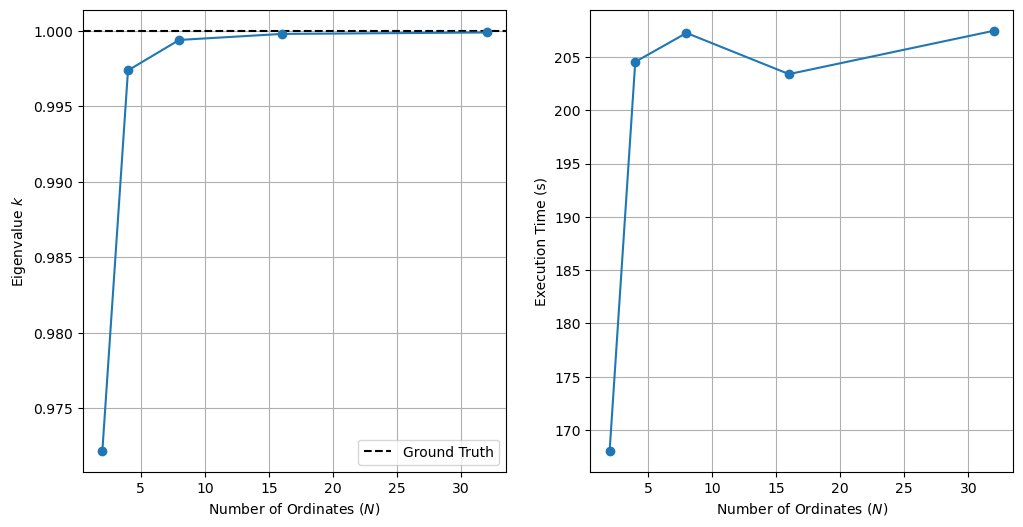

In [14]:
# Get problem specific XSs and geometry
xs_server, geometry = problems.research_reactor_anisotropic(1024, "reflective")

SN = DiscreteOrdinates(
    xs_server=xs_server, 
    geometry=geometry, 
    num_ordinates=16, 
    tol=1e-6, 
    max_iter=1000,
    tt_fmt="tt",
)

num_ordinates_list = np.array([2, 4, 8, 16, 32], dtype=int)

ks = []
exec_times = []
expected_k = 1.0

fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharex=True)
axs[0].axhline(expected_k, color="k", ls="--", label="Ground Truth")

for num_ordinates in num_ordinates_list:
    print(f"-- N = {num_ordinates},", end=" ")
    
    # Update solver
    SN.update_settings(num_ordinates=num_ordinates)
    
    # Run and time solver
    start = time.time()
    k, _ = SN.solve_TT_power()
    stop = time.time()
    
    ks.append(k)
    exec_times.append(stop - start)
        
    print(f"k = {np.round(k, 5)}, exec_time = {np.round(exec_times[-1], 3)} s")

axs[0].plot(num_ordinates_list, ks, "-o")
axs[1].plot(num_ordinates_list, exec_times, "-o")

axs[0].set(xlabel="Number of Ordinates ($N$)", ylabel="Eigenvalue $k$")
axs[1].set(xlabel="Number of Ordinates ($N$)", ylabel="Execution Time (s)")

axs[0].legend()

plt.show()